In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from scipy.signal import savgol_filter
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from support.imu_calculations import *

In [2]:
A = np.array([[0.999065, 0.000183, -0.002879],
                [0.000183, 0.996657, -0.000375],
                [-0.002879, -0.000375, 1.007448]])
# 'Combined bias (b)' vector from Magneto
b = np.array([0.165054, -0.253958, 0.136449]).reshape(3,1)

In [3]:
_parent_folder = "omni_9dof_april_25_2023"
_folder_name = "sk33_00_rotation_01"
_base_pth = os.path.dirname(os.getcwd())
# _base_pth = os.path.dirname(_base_pth)
_base_pth = os.path.join(_base_pth,"recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\omni_9dof_april_25_2023'

In [4]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time"}, inplace=True)
_sk_df = pl.from_pandas(_sk_df)

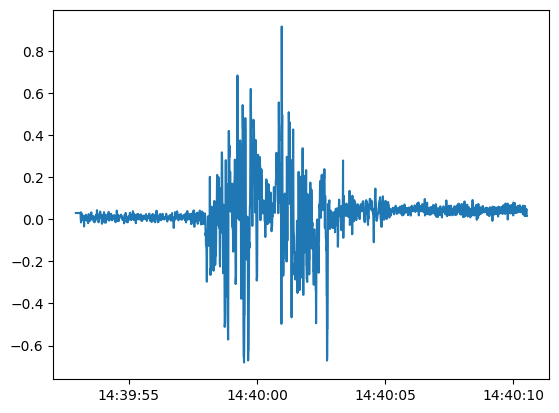

In [5]:
plt.plot(_sk_df["time"], _sk_df["ax"], label="accel_x")

In [6]:
"""calibrate the accelerometer"""
# subtract the bias vector from the accelerometer values
_sk_df = _sk_df.with_columns([
                                pl.col("ax") - b[0],
                                pl.col("ay") - b[1],
                                pl.col("az") - b[2],
                            ])

# multiply the values with the combined misalignment matrix
for i in range(len(_sk_df)):
    temp = np.dot(A, np.array([_sk_df["ax"][i], _sk_df["ay"][i], _sk_df["az"][i]]).reshape(3,1))
    _sk_df["ax"][i] = temp[0]
    _sk_df["ay"][i] = temp[1]
    _sk_df["az"][i] = temp[2]

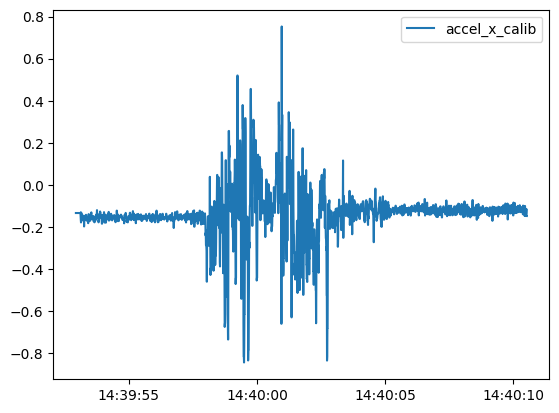

In [7]:
plt.plot(_sk_df["time"], _sk_df["ax"], label="accel_x_calib")
plt.legend()

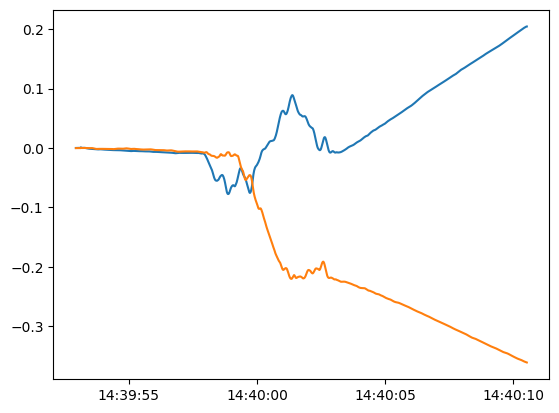

In [8]:
# apply savgol filter to the ax, ay, az values


df = calculate_imu_velocity(_sk_df, filter_size = 101, filter_order=9,  dt=0.007)
df = calculate_imu_orientation(df, filter_size = 101, filter_order=1, dt=0.007)
# df = calculate_imu_displacement(df,filter_size = 101, filter_order = 9, dt=0.007)
plt.plot(df["time"], df["vx"], label="vx")
plt.plot(df["time"], df["vy"], label="vy")

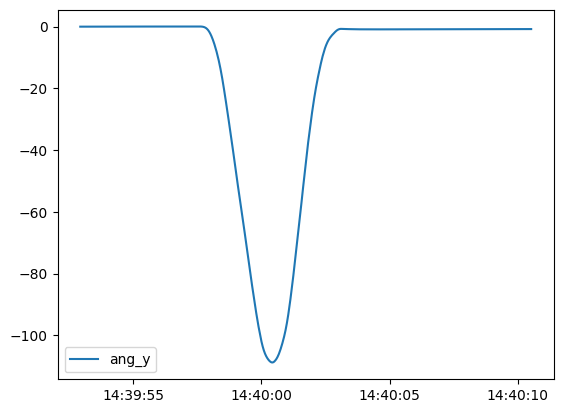

In [19]:
# plt.plot(df["time"], df["ang_x"], label="ang_x")
plt.plot(df["time"], df["ang_z"]*9.81, label="ang_y")
plt.legend()

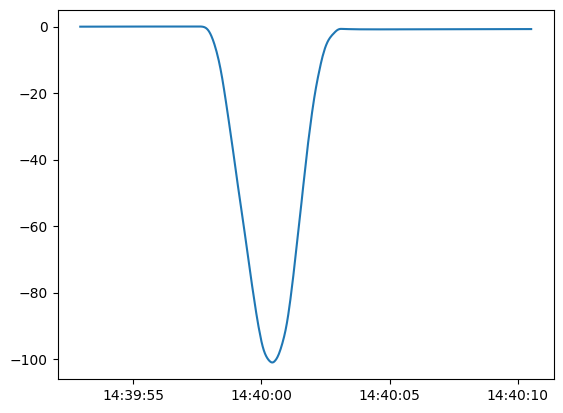

In [23]:
plt.plot(df["time"], df["gz"].cumsum()*0.0065 * 9.81 , label="dis_x")